In [159]:
# Generics
import numpy as np 
import math
import random
import copy

# Plotting 
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from mpl_toolkits.mplot3d import Axes3D

plt.style.use('seaborn')

In [177]:
class Individu() : 
    def __init__(self, function, c_len, r1, r2) :
        self.function = function 
        self.c_len = c_len 
        self.r1 = r1 
        self.r2 = r2 
        self.chromosome = np.random.randint(2, size=c_len)
        self.update_state() 

    def fitness_function(self, hx) : 
        return -hx

    def decode(self, chromosome, rmin, rmax) : 
        """
        this function convert binary chromosome into single real values
        """
        n = len(chromosome)
        sig = 0
        sum = 0
        for i, gen in enumerate(chromosome): 
            sig += math.pow(2, -(i+1))
            sum += gen * math.pow(2, -(i+1))
        return rmin + ((rmax - rmin)/sig * sum)

    def update_state(self) : 
        """
        this method assign x1 and x2 using decode function and calculate fitness and function values
        """
        self.x1 = self.decode(self.chromosome[0:len(self.chromosome)//2], self.r1[0], self.r1[1])
        self.x2 = self.decode(self.chromosome[len(self.chromosome)//2 :], self.r2[0], self.r2[1])
        self.hx = self.function(self.x1, self.x2) 
        self.fitness = self.fitness_function(self.hx)

    def update_gen(self, new) : 
        """
        this method used to update chromosome with new chromosome
        """
        self.chromosome = new 
        self.update_state()

    def set_probability(self, _sum, _min) : 
        """
        this method count the probability for individual to be chosen in roulette
        """
        self.probability = (self.fitness + abs(_min) + 0.01) / _sum

class Population() : 
    def __init__(self, size, function, c_len, r1, r2) : 
        self.size = size 
        self.individu = self.init_population(function, c_len, r1, r2)
        self.update_state() 

    def init_population(self, function, c_len, r1, r2) : 
        """
        initialize population with size of self.size
        """
        individu = []
        for i in range(self.size): 
            individu.append(Individu(function, c_len, r1, r2))
        return np.array(individu) 

    def update_state(self) : 
        """
        update the state of population such as fittest
        least fittest, and second least fittest 

        used before changing into newer generation
        """
        self.individu = sorted(self.individu, key=lambda x: x.fitness, reverse=True) 
        self.fittest = self.individu[0]
        self.least_fittest = self.individu[-1]
        self.second_least_fittest = self.individu[-2]
        self.average_fitness = np.mean([individu.fitness for individu in self.individu])


class GADriver() : 

    def __init__(self, population, pc, pm) : 
        self.population = population
        self.pc = pc
        self.pm = pm

    def stochastic_roulette(self) :
        """
        Stochastic roulette wheel
        """
        _min = min(individu.fitness for individu in self.population.individu)
        _sum = sum(individu.fitness + abs(_min) + 0.01 for individu in self.population.individu)
        _max = max(individu.fitness + abs(_min) + 0.01 for individu in self.population.individu)
        
        def getidx() : 
            while True :
                indv = random.randint(0, self.population.size - 1) 
                r = random.uniform(0, 1)
                if (r < (self.population.individu[indv].fitness + abs(_min))/_max) : 
                    p = indv 
                    break
            return p

        self.parent = copy.copy(self.population.individu[getidx()])
        self.second_parent = copy.copy(self.population.individu[getidx()])

    def uniform_crossover(self) : 
        """
        this method return result of uniform crossover with pattern between two chromosome
        that is parent and second parent's chromosomes 

        this function return two new chromosome, offspring1 and offspring2
        """

        pola = np.random.randint(2, size=self.population.fittest.c_len)
        c1 = copy.copy(self.parent.chromosome)
        c2 = copy.copy(self.second_parent.chromosome)

        for i in range(len(c1)) : 
            if pola[i] == 1 : 
                c1[i], c2[i] = c2[i], c1[i]

        return c1, c2
            
    def mutation(self, c1, c2) :
        """
        this method return result of mutation, loop through genes 
        if the probability of random is 1 then mutation occurs, 
        genes that is 1 change to 0 if its 0 than it changes into 1

        this function return two new chromosome, offspring1 and offspring2
        """

        for i in range(self.population.fittest.c_len) :
            rand = random.choices([0, 1], [(1 - self.pm), self.pm])[0]
            if rand == 1 : 
                c1[i] = 1 if c1[i] == 0 else 0 
                c2[i] = 1 if c2[i] == 0 else 0 

        return c1, c2

    def train(self, n_gen) :
        
        # parent selection methods 
        fit_history = []
        val_history = [] 
        avg_history = []
        x1_history  = []
        x2_history  = []

        it = 1
        for i in range(n_gen) : 

            
            fit_history.append(self.population.fittest.fitness)
            val_history.append(self.population.fittest.hx)
            avg_history.append(self.population.average_fitness)
            x1_history.append (self.population.fittest.x1)
            x2_history.append (self.population.fittest.x2)

            print("Gen-{}".format(it))
            print("-"*10)
            print("Fittest")
            print("Chromosome : ", self.population.fittest.chromosome)
            print("x1, x2     : ", self.population.fittest.x1, self.population.fittest.x2)
            print("Func Value : ", self.population.fittest.hx)
            print("Fitness    : ", self.population.fittest.fitness)
            print("")

            # roulette, get two parents
            self.stochastic_roulette()

            # crossover, return two offsprings
            offspring1, offspring2 = self.uniform_crossover()

            # mutation, return mutated two offsprings
            offspring1, offspring2 = self.mutation(offspring1, offspring2) 

            # Steady State, replace two worst fitness chromosome with newest offspring
            self.population.least_fittest.update_gen(offspring1) 
            self.population.second_least_fittest.update_gen(offspring2)

            # update state, fittest, least_fittest, second_fittest
            self.population.update_state()

            it+=1

        return fit_history, avg_history, val_history, x1_history, x2_history


In [180]:
# mathematical function (to be minimized)
def h_func(x1, x2) : 
  return math.cos(x1) * math.sin(x2) - x1 / ((x2)**2 + 1)

function=h_func


# Settings parmeter 

# ukuran populasi
size=8
# panjang kromosom
c_len=16

# rmin, rmax
r1 = [-1, 2]
r2 = [-1, 1]

# peluang crossover
pc = 0.8

# peluang mutasi
pm = 0.1

# banyaknya generasi
n_gen=100

# object initialization
population = Population(size, function, c_len, r1, r2)
driver = GADriver(population, pc, pm)
fit_history, avg_history, val_history, x1_history, x2_history = driver.train(n_gen)

Gen-1
----------
Fittest
Chromosome :  [1 1 0 0 1 1 0 0 0 1 1 0 0 0 1 1]
x1, x2     :  1.4 -0.22352941176470587
Func Value :  -1.3710543325181752
Fitness    :  1.3710543325181752

Gen-2
----------
Fittest
Chromosome :  [1 1 0 0 1 1 0 0 0 1 1 0 0 0 1 1]
x1, x2     :  1.4 -0.22352941176470587
Func Value :  -1.3710543325181752
Fitness    :  1.3710543325181752

Gen-3
----------
Fittest
Chromosome :  [1 1 0 0 1 1 0 0 0 1 1 0 0 0 1 1]
x1, x2     :  1.4 -0.22352941176470587
Func Value :  -1.3710543325181752
Fitness    :  1.3710543325181752

Gen-4
----------
Fittest
Chromosome :  [1 1 1 0 1 1 0 1 0 1 1 0 1 0 1 1]
x1, x2     :  1.788235294117647 -0.16078431372549018
Func Value :  -1.708634847072198
Fitness    :  1.708634847072198

Gen-5
----------
Fittest
Chromosome :  [1 1 1 0 1 1 0 1 0 1 1 0 1 0 1 1]
x1, x2     :  1.788235294117647 -0.16078431372549018
Func Value :  -1.708634847072198
Fitness    :  1.708634847072198

Gen-6
----------
Fittest
Chromosome :  [1 1 1 0 1 1 0 1 0 1 1 0 1 0 1 1]
x1,

In [181]:
x = np.linspace(-1, 2, num=100)
y = np.linspace(-1, 1, num=100)
xs, ys = np.meshgrid(x, y)
zs = np.cos(xs) * np.sin(ys) - xs / ((ys)**2 + 1)

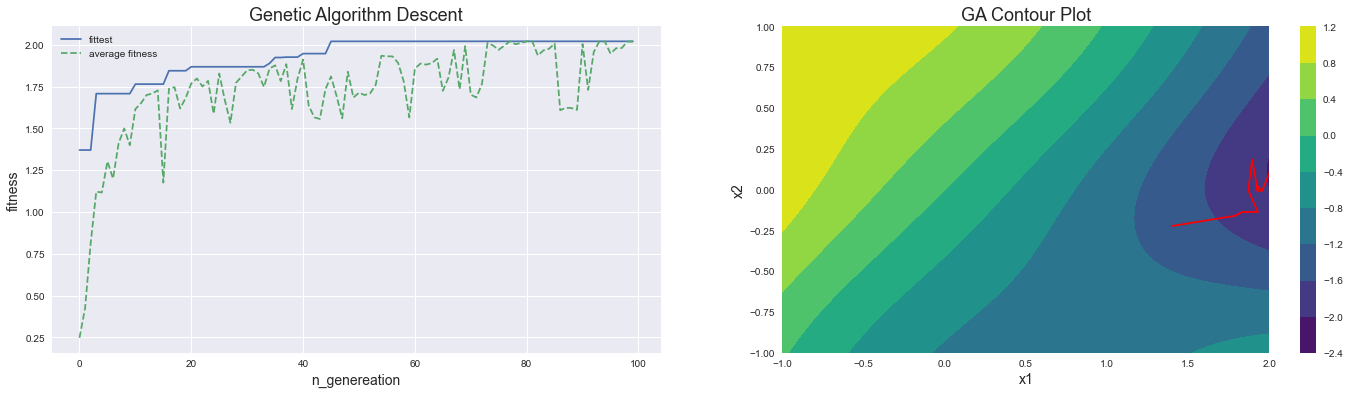

In [182]:
fig, ax = plt.subplots(1, 2, figsize=(24,6))
ax[0].plot(fit_history, label='fittest')
ax[0].set_xlabel("n_genereation", fontsize=14)
ax[0].set_ylabel("fitness", fontsize=14)
ax[0].set_title("Genetic Algorithm Descent", fontsize=18)
ax[0].plot(avg_history, label='average fitness', linestyle='dashed')

ax[0].legend()

cp = ax[1].contourf(xs, ys, zs, cmap='viridis')
ax[1].set_xlabel('x1', fontsize=14)
ax[1].set_ylabel('x2', fontsize=14)
ax[1].set_title('GA Contour Plot', fontsize=18)

ax[1].plot(x1_history, x2_history, color='r')
fig.colorbar(cp)

fig.show()
fig.savefig("contour")

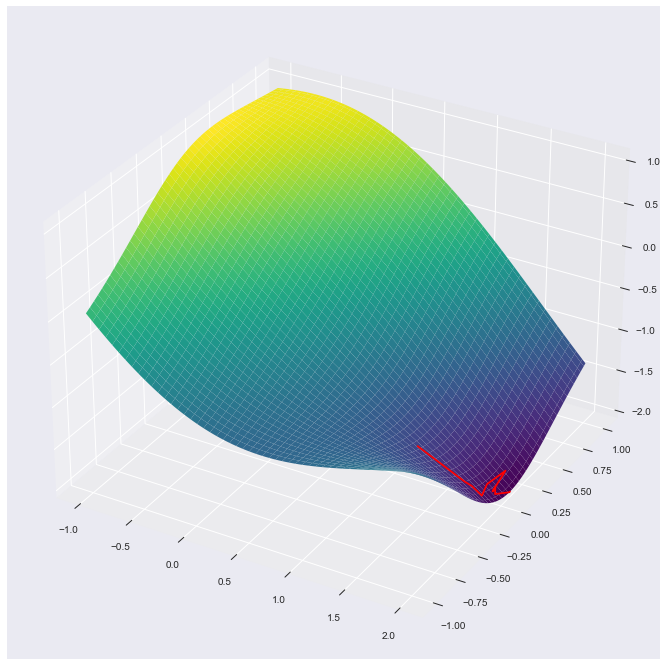

In [183]:
fig = plt.figure(figsize=(24,12)) 
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xs, ys, zs, cmap='viridis', edgecolor='none')
ax.plot(x1_history, x2_history, val_history, color='r')

fig.show()
fig.savefig("3dplot")

### Interactive Plot

In [184]:
fig = make_subplots()

fig.add_trace(go.Surface(
    x = x,
    y = y,
    z = zs,
))

fig.add_trace(go.Scatter3d(
    x=x1_history,
    y=x2_history, 
    z=val_history, 
    name="Fitness Step",
    mode='lines+markers'
))

fig.update_layout(
    title='Genetic Algorithm Descent', 
    showlegend=True,
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1), 
    scene = dict(
        xaxis_title='x1 values',
        yaxis_title='x2 values',
        zaxis_title='Function values'),
)
fig.show()

In [185]:
fig = make_subplots()

fig.add_trace(go.Contour(
    x = x,
    y = y,
    z = zs,
))

fig.add_trace(go.Scatter(
    x=x1_history,
    y=x2_history,
    mode='lines+markers',
    name='Fittest step'
))

fig.update_layout(
    title='Genetic Algorithm Contour', 
    showlegend=True,
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1), 
)
fig.show()